In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
remoras = np.load("data/normalized_remora_track_video_2.npy")
shark = np.load("data/normalized_shark_track_video_2.npy")

remoras = remoras[:, :6]

# remoras = np.load("data/normalized_remora_track_video_3.npy")
# shark = np.load("data/normalized_shark_track_video_3.npy")

n_frames, n_remoras, _ = remoras.shape
n_shark_nodes = shark.shape[1]

avg_shark = np.nanmean(shark, axis=0)
shark_inds = [4, 3, 0, 1, 2]

remoras.shape, shark.shape

((568, 6, 2), (568, 5, 2))

Text(0.5, 1.0, 'Whale shark-centric trajectories')

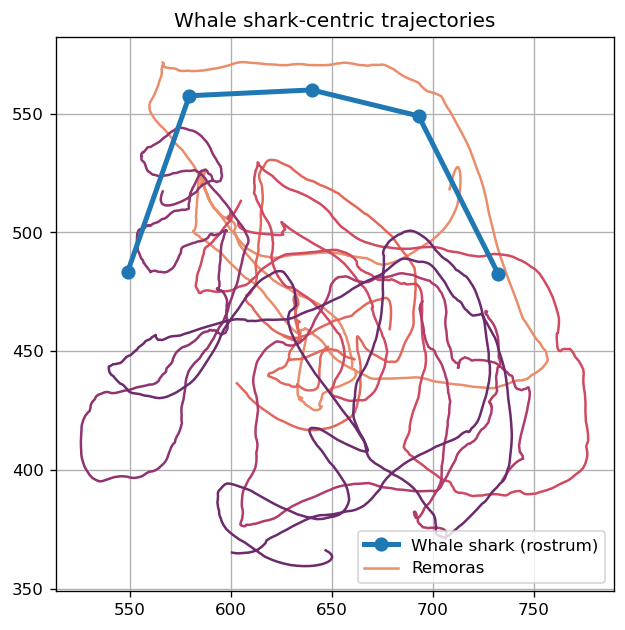

In [3]:
remora_cols = sns.color_palette("flare", n_colors=n_remoras)

plt.figure(figsize=(6, 6), dpi=120)
plt.plot(avg_shark[shark_inds, 0], avg_shark[shark_inds, 1], ".-", lw=3, ms=15, zorder=n_remoras+1, label="Whale shark (rostrum)")
for i in range(n_remoras):
    plt.plot(remoras[:, i, 0], remoras[:, i, 1], "-", c=remora_cols[i], label="Remoras" if i == 0 else None)
plt.legend()
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.gca().yaxis.set_inverted(True)
plt.title("Whale shark-centric trajectories")

Text(0.5, 1.0, 'Whale shark-centric remora occupancy')

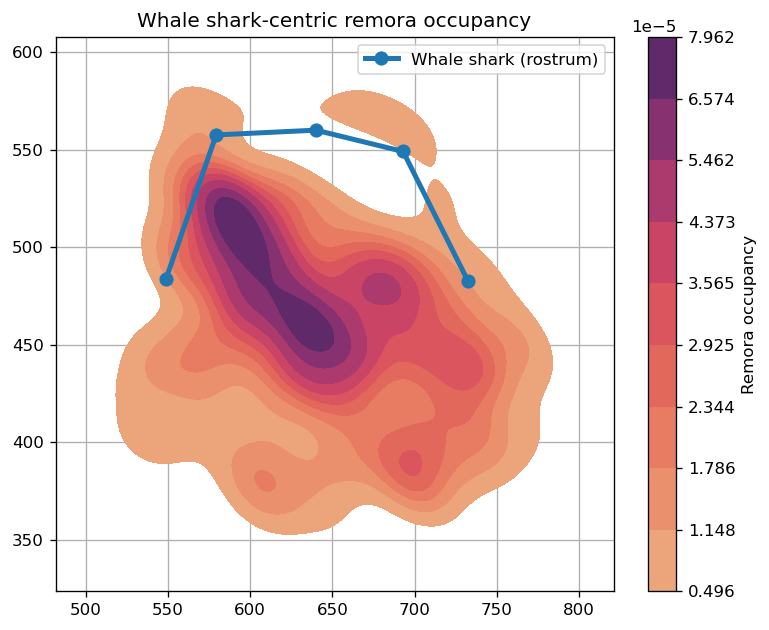

In [4]:
plt.figure(figsize=(7.5, 6), dpi=120)
plt.plot(avg_shark[shark_inds, 0], avg_shark[shark_inds, 1], ".-", lw=3, ms=15, label="Whale shark (rostrum)")

sns.kdeplot(x=remoras[...,0].flatten(), y=remoras[...,1].flatten(), fill=True, cmap="flare", cbar=True, cbar_kws={"label": "Remora occupancy"})

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
plt.legend()
plt.title("Whale shark-centric remora occupancy")

In [5]:
import numpy as np
from typing import Optional


def signed_angle(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Finds the signed angle between two 2D vectors a and b.
    Args:
        a: Array of shape (n, 2).
        b: Array of shape (n, 2).
    Returns:
        The signed angles in degrees in vector of shape (n, 2).
        This angle is positive if a is rotated clockwise to align to b and negative if
        this rotation is counter-clockwise.
    """
    a = a / np.linalg.norm(a, axis=1, keepdims=True)
    b = b / np.linalg.norm(b, axis=1, keepdims=True)
    theta = np.arccos(np.around(np.sum(a * b, axis=1), decimals=4))
    cross = np.cross(a, b, axis=1)
    sign = np.zeros(cross.shape)
    sign[cross >= 0] = -1
    sign[cross < 0] = 1
    return np.rad2deg(theta) * sign


def normalize_to_egocentric(
    x: np.ndarray,
    rel_to: Optional[np.ndarray] = None,
    ctr_ind: int = 0,
    fwd_ind: int = -1,
    return_angles: bool = False,
):
    """Normalize pose estimates to egocentric coordinates.
    Args:
        x: Pose of shape (joints, 2) or (time, joints, 2)
        rel_to: Pose to align x with of shape (joints, 2) or (time, joints, 2). Defaults
            to x if not specified.
        ctr_ind: Index of centroid joint. Defaults to MOUSE_CENTER_BACK.
        fwd_ind: Index of "forward" joint (e.g., head). Defaults to MOUSE_NECK.
        return_angles: If True, return angles with the aligned coordinates.
    Returns:
        Egocentrically aligned poses of the same shape as the input.
        If return_angles is True, also returns a vector of angles.
    """

    if rel_to is None:
        rel_to = x

    is_singleton = (x.ndim == 2) and (rel_to.ndim == 2)

    if x.ndim == 2:
        x = np.expand_dims(x, axis=0)
    if rel_to.ndim == 2:
        rel_to = np.expand_dims(rel_to, axis=0)

    # Find egocentric forward coordinates.
    ctr = rel_to[..., ctr_ind, :]  # (t, 2)
    fwd = rel_to[..., fwd_ind, :]  # (t, 2)
    ego_fwd = fwd - ctr

    # Compute angle.
    ang = np.arctan2(
        ego_fwd[..., 1], ego_fwd[..., 0]
    )  # arctan2(y, x) -> radians in [-pi, pi]
    ca = np.cos(ang)  # (t,)
    sa = np.sin(ang)  # (t,)

    # Build rotation matrix.
    rot = np.zeros([len(ca), 3, 3], dtype=ca.dtype)
    rot[..., 0, 0] = ca
    rot[..., 0, 1] = -sa
    rot[..., 1, 0] = sa
    rot[..., 1, 1] = ca
    rot[..., 2, 2] = 1

    # Center.
    x = x - np.expand_dims(ctr, axis=1)

    # Pad, rotate and crop.
    x = np.pad(x, ((0, 0), (0, 0), (0, 1)), "constant", constant_values=1) @ rot
    x = x[..., :2]

    if is_singleton:
        x = x[0]

    if return_angles:
        return x, ang
    else:
        return x

In [6]:
remoras_lagged = np.stack([remoras, np.concatenate([remoras[1:], remoras[[-1]]], axis=0)], axis=2)
remoras_lagged.shape

(568, 6, 2, 2)

In [7]:
shark_ego = np.full((n_frames, n_remoras, n_shark_nodes, 2), np.nan)
remoras_ego = np.full((n_frames, n_remoras, n_remoras, 2, 2), np.nan)

for i in range(n_remoras):
    shark_ego[:, i] = normalize_to_egocentric(shark, rel_to=remoras_lagged[:, i])
    for j in range(n_remoras):
        remoras_ego[:, i, j] = normalize_to_egocentric(remoras_lagged[:, j], rel_to=remoras_lagged[:, i])

In [8]:
remoras_ego[0, 0, 0]

array([[0.00000000e+00, 0.00000000e+00],
       [4.09384410e+00, 2.70979847e-16]])

Text(0.5, 1.0, 'Remora-centric trajectories')

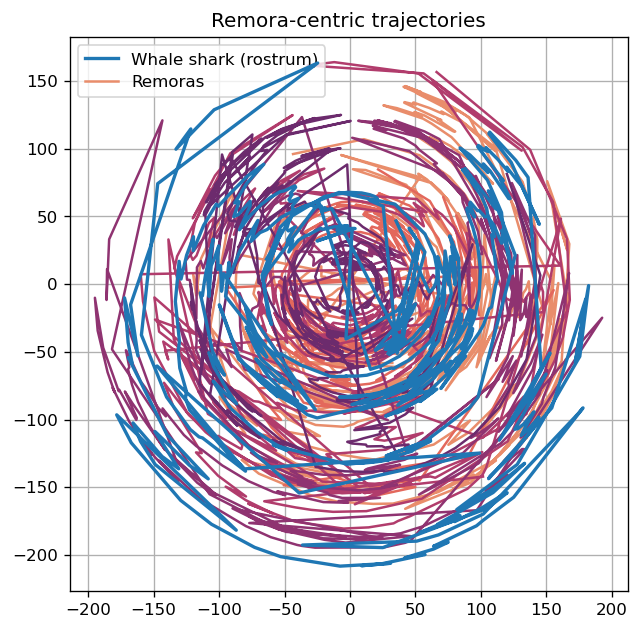

In [9]:
ref_ind = 2

shark_ego_ref = shark_ego[:, ref_ind]
avg_shark_ego_ref = np.nanmean(shark_ego_ref, axis=0)
remoras_ego_ref = remoras_ego[:, ref_ind, :, 0]

remora_cols = sns.color_palette("flare", n_colors=n_remoras)

plt.figure(figsize=(6, 6), dpi=120)
# plt.plot(avg_shark_ego_ref[shark_inds, 0], avg_shark_ego_ref[shark_inds, 1], ".-", lw=3, ms=15, zorder=n_remoras+1, label="Whale shark (rostrum)")
plt.plot(shark_ego_ref[:, 0, 0], shark_ego_ref[:, 0, 1], "-", lw=2, zorder=n_remoras+1, label="Whale shark (rostrum)")
remora_labeled = False
for i in range(n_remoras):
    if i == ref_ind:
        continue
    plt.plot(remoras_ego_ref[:, i, 0], remoras_ego_ref[:, i, 1], "-", c=remora_cols[i], label="Remoras" if not remora_labeled else None)
    remora_labeled = True
plt.legend()
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.gca().yaxis.set_inverted(True)
plt.title("Remora-centric trajectories")

Text(0.5, 1.0, 'Remora-centric occupancy')

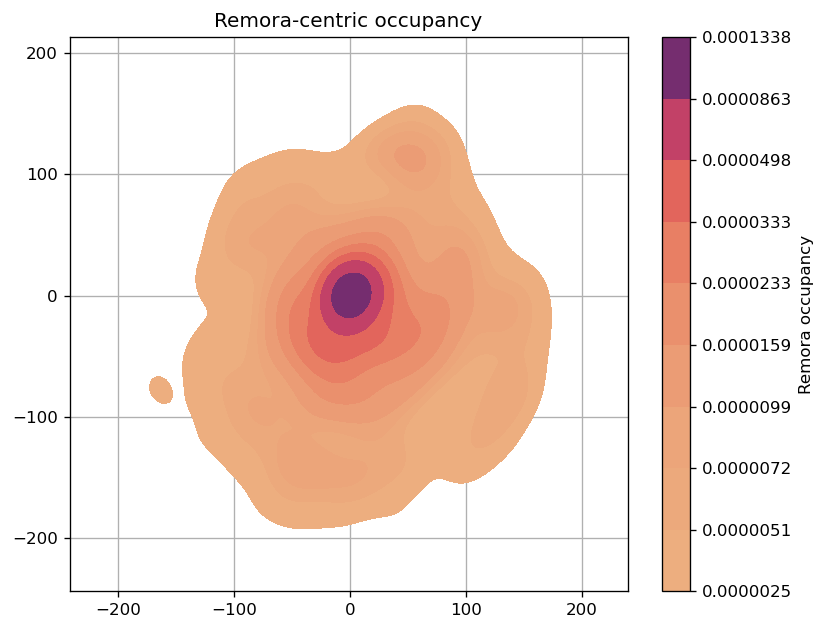

In [10]:
ref_ind = 2

shark_ego_ref = shark_ego[:, ref_ind]
remoras_ego_ref = remoras_ego[:, ref_ind, :, 0]

plt.figure(figsize=(7.5, 6), dpi=120)
# plt.plot(avg_shark[shark_inds, 0], avg_shark[shark_inds, 1], ".-", lw=3, ms=15, label="Whale shark (rostrum)")

sns.kdeplot(x=remoras_ego_ref[...,0].flatten(), y=remoras_ego_ref[...,1].flatten(), fill=True, cmap="flare", cbar=True, cbar_kws={"label": "Remora occupancy"})

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.title("Remora-centric occupancy")

Text(0.5, 1.0, 'Remora-centric occupancy')

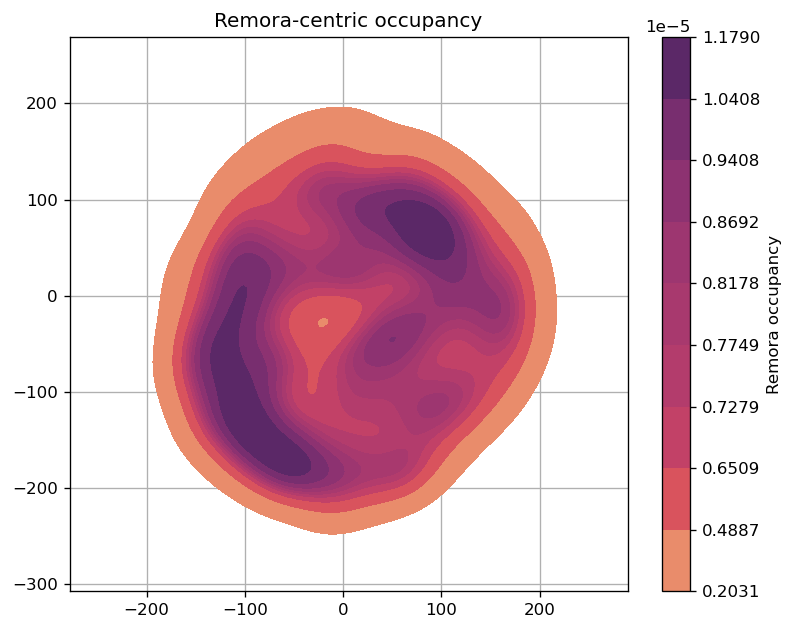

In [11]:
ref_ind = 5

shark_ego_ref = shark_ego[:, ref_ind]
remoras_ego_ref = remoras_ego[:, ref_ind, :, 0]

plt.figure(figsize=(7.5, 6), dpi=120)
# plt.plot(avg_shark[shark_inds, 0], avg_shark[shark_inds, 1], ".-", lw=3, ms=15, label="Whale shark (rostrum)")

sns.kdeplot(x=shark_ego_ref[...,0].flatten(), y=shark_ego_ref[...,1].flatten(), fill=True, cmap="flare", cbar=True, cbar_kws={"label": "Remora occupancy"})

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.title("Remora-centric occupancy")

In [12]:
def circular_hist(x, ax=None, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    x : array
        Angles to plot, expected in units of radians.
        
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
        
    Reference
    ---------
    https://stackoverflow.com/a/55067613/1939934
    """
    if ax is None:
        import matplotlib.pyplot as plt
        ax = plt.subplot(111, projection="polar")
        
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

Text(0.5, 1.0, 'Remora-centric occupancy')

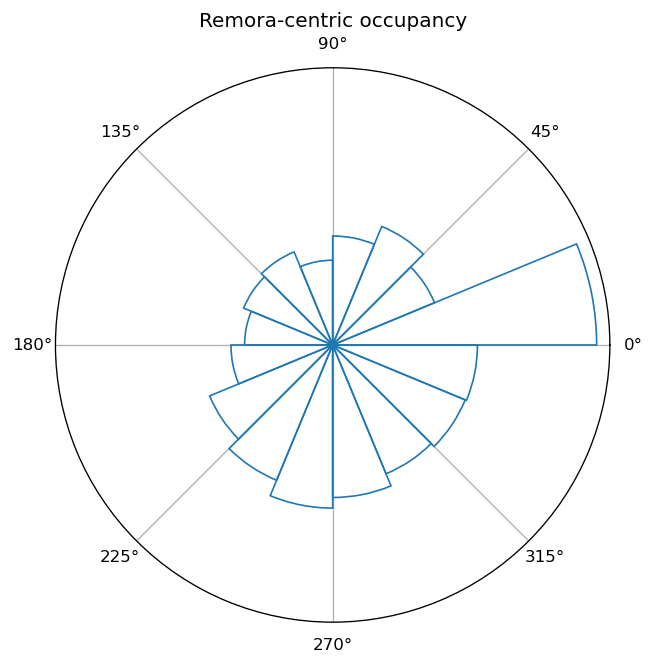

In [13]:
ref_ind = 2

shark_ego_ref = shark_ego[:, ref_ind]
remoras_ego_ref = remoras_ego[:, ref_ind, :, 0]

plt.figure(figsize=(7.5, 6), dpi=120)
# plt.plot(avg_shark[shark_inds, 0], avg_shark[shark_inds, 1], ".-", lw=3, ms=15, label="Whale shark (rostrum)")

# sns.kdeplot(x=remoras_ego_ref[...,0].flatten(), y=remoras_ego_ref[...,1].flatten(), fill=True, cmap="flare", cbar=True, cbar_kws={"label": "Remora occupancy"})

shark_angs = np.arctan2(shark_ego_ref[..., 1], shark_ego_ref[..., 0])
remora_angs = np.arctan2(remoras_ego_ref[..., 1], remoras_ego_ref[..., 0])

circular_hist(remora_angs.flatten(), gaps=False)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.title("Remora-centric occupancy")

Text(0.5, 1.0, 'Remora-centric occupancy')

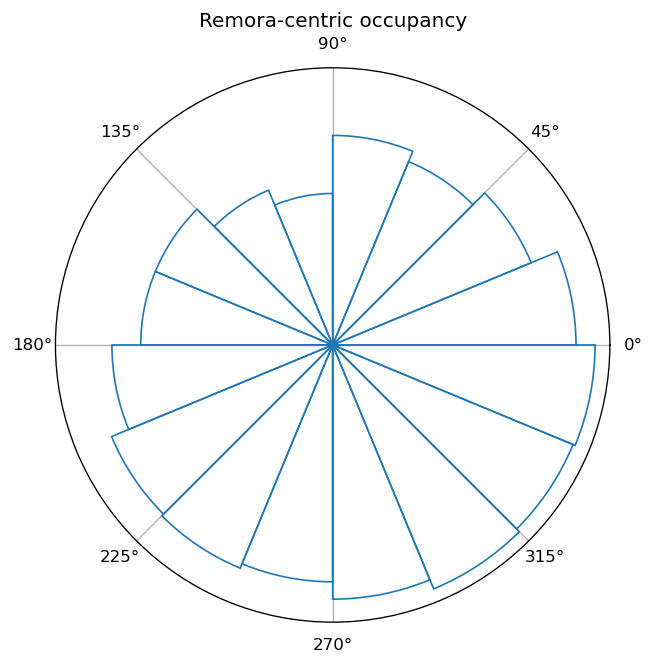

In [14]:
ref_ind = 2

shark_ego_ref = shark_ego[:, ref_ind]
remoras_ego_ref = remoras_ego[:, ref_ind, :, 0]

plt.figure(figsize=(7.5, 6), dpi=120)
# plt.plot(avg_shark[shark_inds, 0], avg_shark[shark_inds, 1], ".-", lw=3, ms=15, label="Whale shark (rostrum)")

# sns.kdeplot(x=remoras_ego_ref[...,0].flatten(), y=remoras_ego_ref[...,1].flatten(), fill=True, cmap="flare", cbar=True, cbar_kws={"label": "Remora occupancy"})

shark_angs = np.arctan2(shark_ego_ref[..., 1], shark_ego_ref[..., 0])
remora_angs = np.arctan2(remoras_ego_ref[..., 1], remoras_ego_ref[..., 0])

circular_hist(shark_angs.flatten(), gaps=False)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.title("Remora-centric occupancy")

Text(0.5, 1.0, 'Remora-centric shark occupancy')

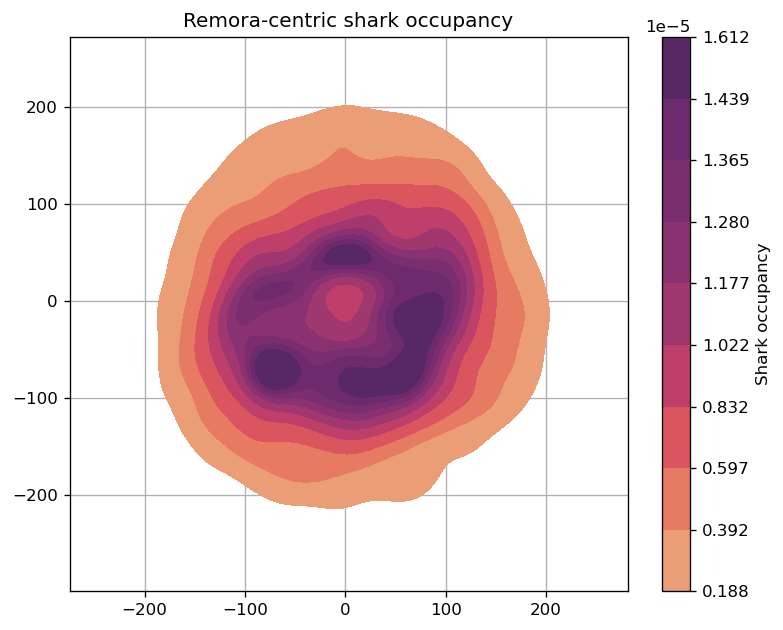

In [15]:
plt.figure(figsize=(7.5, 6), dpi=120)
sns.kdeplot(x=shark_ego[...,0].flatten(), y=shark_ego[...,1].flatten(), fill=True, cmap="flare", cbar=True,
            cbar_kws={"label": "Shark occupancy"})

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.title("Remora-centric shark occupancy")

Text(0.5, 1.0, 'Remora-centric shark occupancy (mid rostrum-only)')

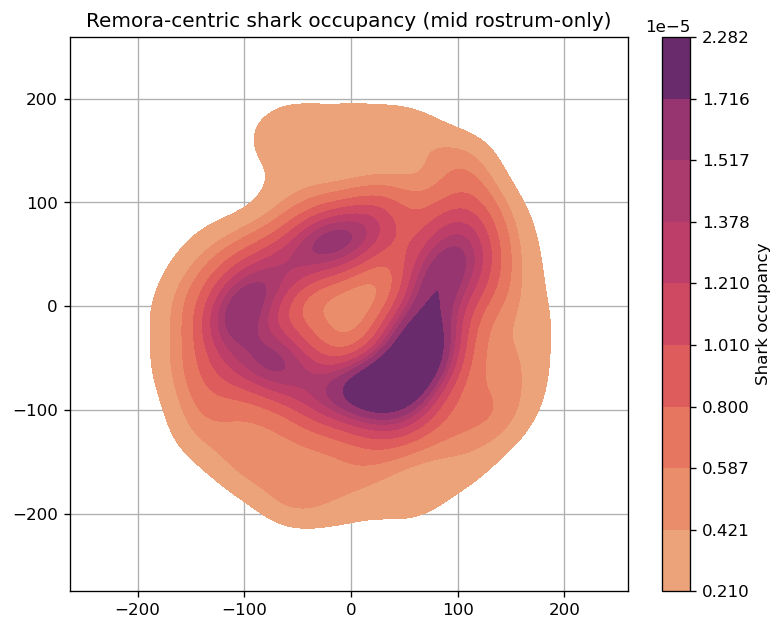

In [16]:
plt.figure(figsize=(7.5, 6), dpi=120)
sns.kdeplot(x=shark_ego[..., 0, 0].flatten(), y=shark_ego[..., 0, 1].flatten(), fill=True, cmap="flare", cbar=True,
            cbar_kws={"label": "Shark occupancy"})

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.title("Remora-centric shark occupancy (mid rostrum-only)")

In [17]:
shark_angs = np.arctan2(shark_ego[...,1], shark_ego[...,0])
shark_radius = np.sqrt((shark_ego[...,0] ** 2) + (shark_ego[...,1] ** 2))

shark_angs.shape, shark_radius.shape

((568, 6, 5), (568, 6, 5))

Text(0.5, 1.0, 'Remora-centric shark occupancy')

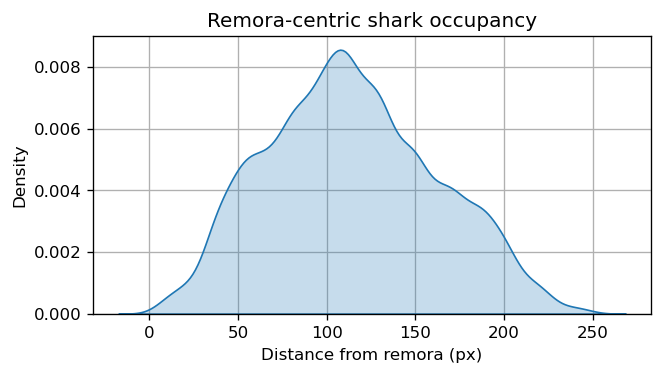

In [18]:
plt.figure(figsize=(6, 3), dpi=120)
sns.kdeplot(x=shark_radius[..., :].flatten(), fill=True)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.xlabel("Distance from remora (px)")
plt.title("Remora-centric shark occupancy")

Text(0.5, 1.0, 'Remora-centric shark occupancy (mid rostrum-only)')

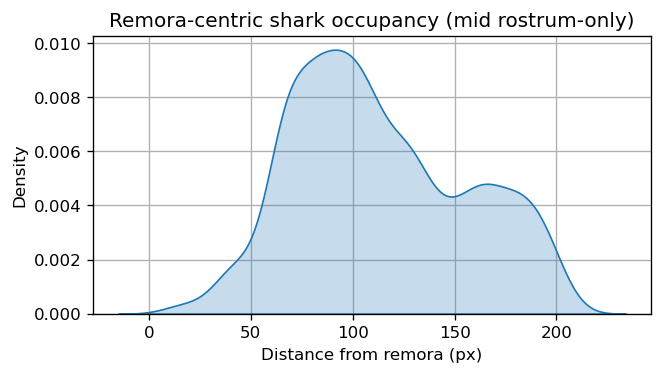

In [19]:
plt.figure(figsize=(6, 3), dpi=120)
sns.kdeplot(x=shark_radius[..., 0].flatten(), fill=True)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.xlabel("Distance from remora (px)")
plt.title("Remora-centric shark occupancy (mid rostrum-only)")

Text(0.5, 1.0, 'Remora-centric shark occupancy (mid rostrum-only; by remora)')

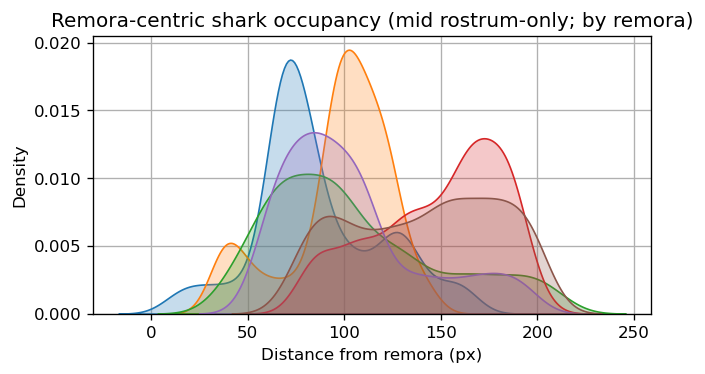

In [20]:
plt.figure(figsize=(6, 3), dpi=120)
for i in range(n_remoras):
    sns.kdeplot(x=shark_radius[:, i, 0].flatten(), fill=True)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.xlabel("Distance from remora (px)")
plt.title("Remora-centric shark occupancy (mid rostrum-only; by remora)")

In [21]:
ref_remora = []
other_remoras = []
for ref_ind in range(n_remoras):
    ref_remora.append(remoras_ego[:, ref_ind, ref_ind])
    other_inds = np.setdiff1d(np.arange(n_remoras), ref_ind)
    other_remoras.append(remoras_ego[:, ref_ind, other_inds])
ref_remora = np.stack(ref_remora, axis=1)
other_remoras = np.stack(other_remoras, axis=1)
other_remoras = other_remoras[..., 0, :]
ref_remora.shape, other_remoras.shape

((568, 6, 2, 2), (568, 6, 5, 2))

1.492272027134878

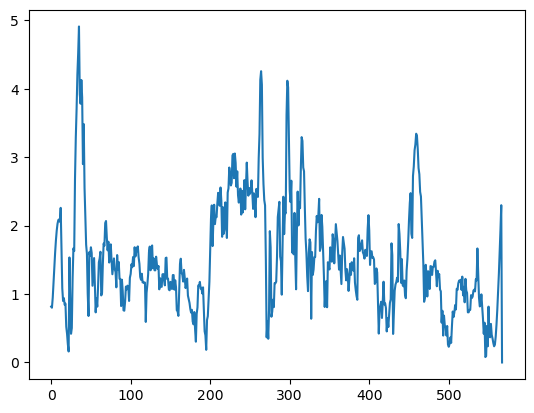

In [22]:
plt.plot(ref_remora[:, 2, 1, 0])
np.nanmean(ref_remora[:, :, 1, 0])

In [23]:
avg_ref_remora = np.nanmean(ref_remora.reshape(-1, 2, 2), axis=0)
avg_ref_remora

array([[0.00000000e+00, 0.00000000e+00],
       [1.49227203e+00, 4.70842453e-18]])

In [24]:
other_remoras_angs = np.arctan2(other_remoras[...,1], shark_ego[...,0])
other_remoras_radius = np.sqrt((other_remoras[...,0] ** 2) + (other_remoras[...,1] ** 2))

other_remoras_angs.shape, other_remoras_radius.shape

((568, 6, 5), (568, 6, 5))

Text(0.5, 1.0, 'Remora-centric other remora occupancy')

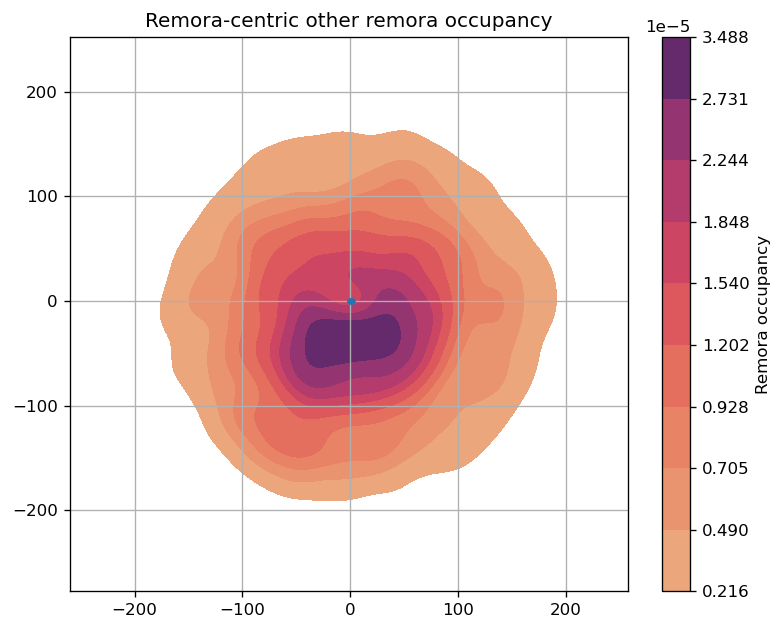

In [25]:
avg_ref_remora = np.nanmean(ref_remora.reshape(-1, 2, 2), axis=0)

plt.figure(figsize=(7.5, 6), dpi=120)
sns.kdeplot(x=other_remoras[...,0].flatten(), y=other_remoras[...,1].flatten(), fill=True, cmap="flare", cbar=True, cbar_kws={"label": "Remora occupancy"})
plt.plot(avg_ref_remora[:, 0], avg_ref_remora[:, 1], ".-")
ax = plt.gca()
# ax.set_axisbelow(True)
ax.grid(True)
plt.title("Remora-centric other remora occupancy")

Text(0.5, 1.0, 'Remora-centric other remora occupancy')

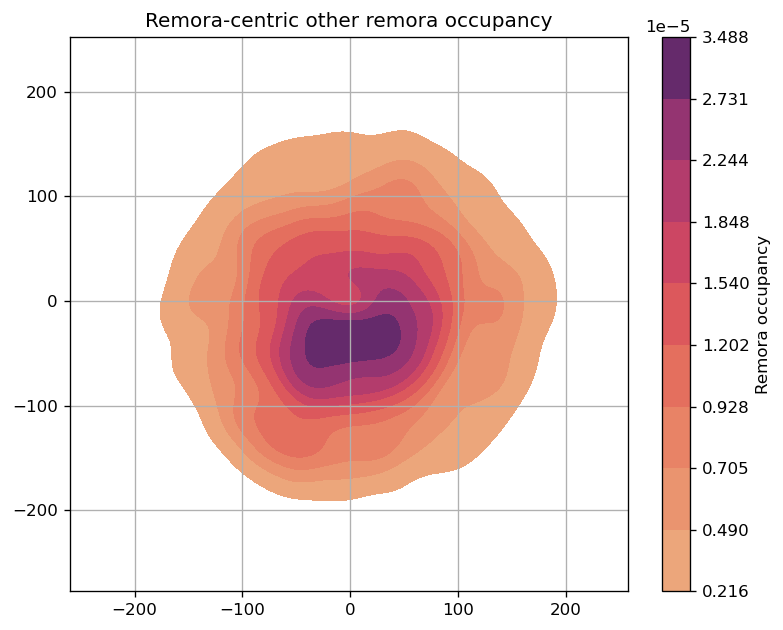

In [26]:
# avg_ref_remora = np.nanmean(ref_remora.reshape(-1, 2, 2), axis=0)

plt.figure(figsize=(7.5, 6), dpi=120)
sns.kdeplot(x=other_remoras[...,0].flatten(), y=other_remoras[...,1].flatten(), fill=True, cmap="flare", cbar=True, cbar_kws={"label": "Remora occupancy"})
# plt.plot(avg_ref_remora[:, 0], avg_ref_remora[:, 1], ".-")
ax = plt.gca()
# ax.set_axisbelow(True)
ax.grid(True)
plt.title("Remora-centric other remora occupancy")

Text(0.5, 1.0, 'Remora-centric other remora occupancy')

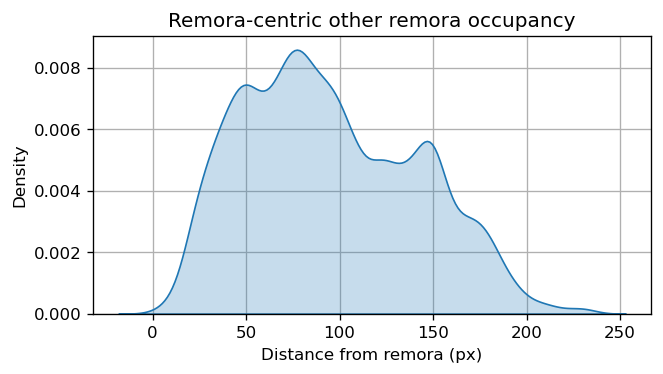

In [27]:
plt.figure(figsize=(6, 3), dpi=120)
sns.kdeplot(x=other_remoras_radius.flatten(), fill=True)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.xlabel("Distance from remora (px)")
plt.title("Remora-centric other remora occupancy")

Text(0.5, 1.0, 'Remora-centric other remora occupancy')

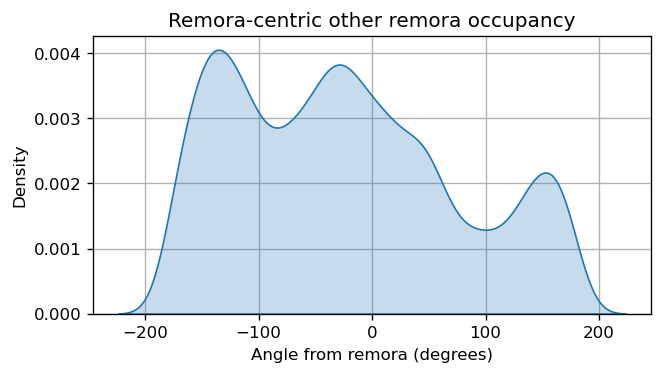

In [28]:
plt.figure(figsize=(6, 3), dpi=120)
sns.kdeplot(x=np.rad2deg(other_remoras_angs.flatten()), fill=True)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.xlabel("Angle from remora (degrees)")
plt.title("Remora-centric other remora occupancy")

Text(0.5, 1.0, 'Remora-centric other remora occupancy')

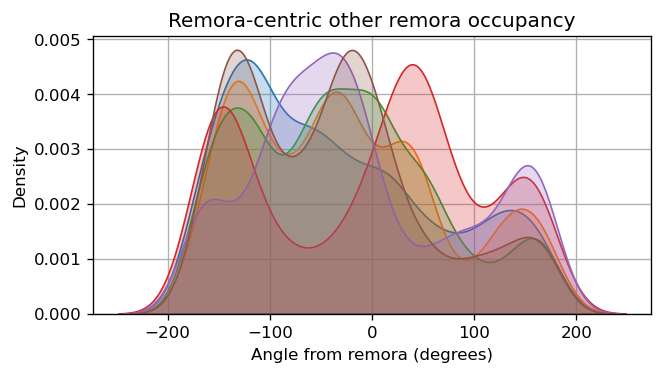

In [29]:
plt.figure(figsize=(6, 3), dpi=120)
for i in range(n_remoras):
    sns.kdeplot(x=np.rad2deg(other_remoras_angs[:, i].flatten()), fill=True)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.xlabel("Angle from remora (degrees)")
plt.title("Remora-centric other remora occupancy")

Text(0.5, 1.0, 'Remora-centric other remora occupancy')

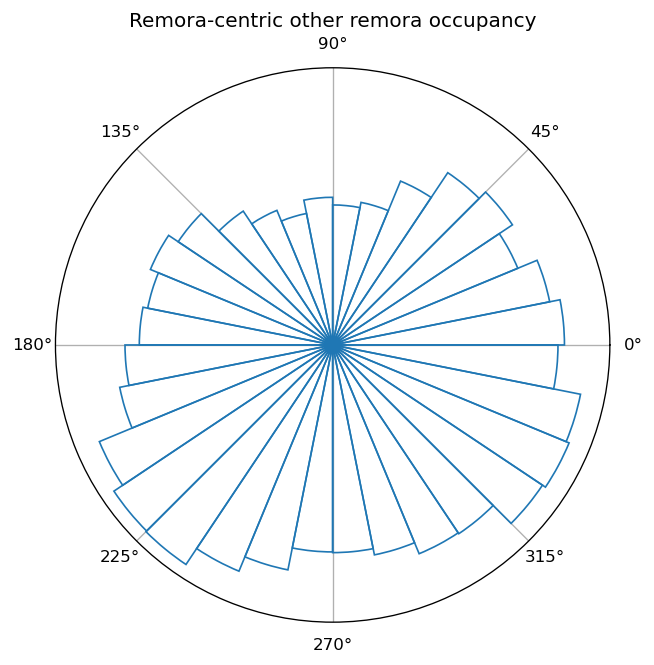

In [30]:
plt.figure(figsize=(6, 6), dpi=120)
circular_hist(other_remoras_angs.flatten(), gaps=False, bins=32)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
# plt.xlabel("Distance from remora (px)")
plt.title("Remora-centric other remora occupancy")

Text(0.5, 1.0, 'Remora-centric other remora occupancy')

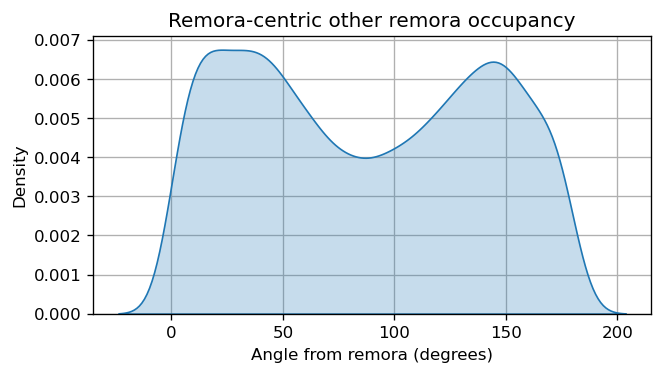

In [31]:
plt.figure(figsize=(6, 3), dpi=120)

sns.kdeplot(x=np.abs(np.rad2deg(other_remoras_angs.flatten())), fill=True)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.xlabel("Angle from remora (degrees)")
plt.title("Remora-centric other remora occupancy")

Text(0.5, 1.0, 'Remora-centric other remora occupancy')

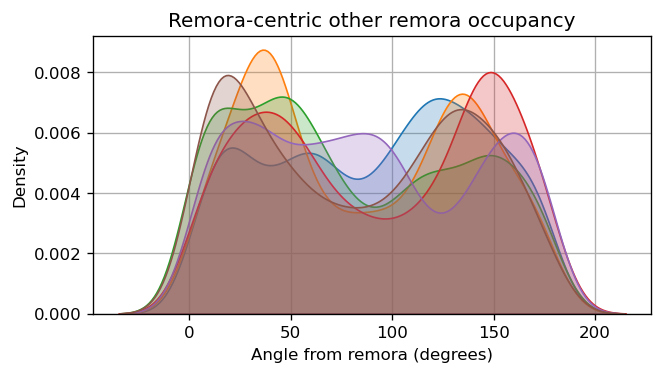

In [32]:
plt.figure(figsize=(6, 3), dpi=120)
for i in range(n_remoras):
    sns.kdeplot(x=np.abs(np.rad2deg(other_remoras_angs[:, i].flatten())), fill=True)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
plt.xlabel("Angle from remora (degrees)")
plt.title("Remora-centric other remora occupancy")

Text(0.5, 1.0, 'Remora-centric other remora occupancy')

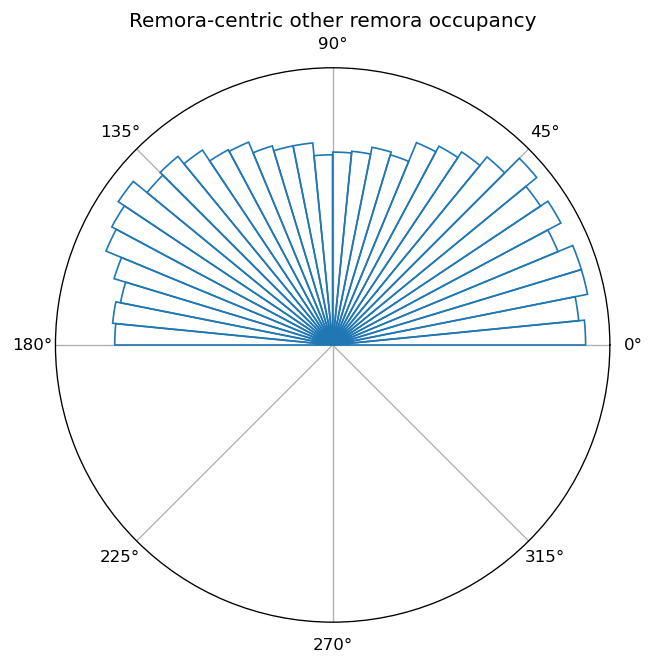

In [33]:
plt.figure(figsize=(6, 6), dpi=120)
circular_hist(np.abs(other_remoras_angs.flatten()), gaps=False, bins=64)

ax = plt.gca()
ax.set_axisbelow(True)
ax.grid(True)
# plt.legend()
# plt.xlabel("Distance from remora (px)")
plt.title("Remora-centric other remora occupancy")